In [1]:
%matplotlib inline


# Selecting dimensionality reduction with Pipeline and GridSearchCV


This example constructs a pipeline that does dimensionality
reduction followed by prediction with a support vector
classifier. It demonstrates the use of ``GridSearchCV`` and
``Pipeline`` to optimize over different classes of estimators in a
single CV run -- unsupervised ``PCA`` and ``NMF`` dimensionality
reductions are compared to univariate feature selection during
the grid search.

Additionally, ``Pipeline`` can be instantiated with the ``memory``
argument to memoize the transformers within the pipeline, avoiding to fit
again the same transformers over and over.

Note that the use of ``memory`` to enable caching becomes interesting when the
fitting of a transformer is costly.



Illustration of ``Pipeline`` and ``GridSearchCV``
##############################################################################
 This section illustrates the use of a ``Pipeline`` with
 ``GridSearchCV``



Automatically created module for IPython interactive environment


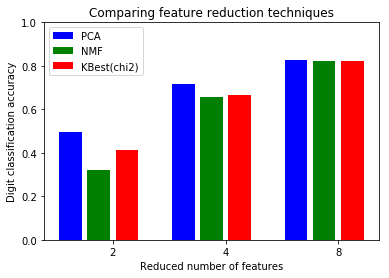

In [2]:
# Authors: Robert McGibbon, Joel Nothman, Guillaume Lemaitre

from __future__ import print_function, division

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA, NMF
from sklearn.feature_selection import SelectKBest, chi2

print(__doc__)

pipe = Pipeline([
    ('reduce_dim', PCA()),
    ('classify', LinearSVC())
])

N_FEATURES_OPTIONS = [2, 4, 8]
C_OPTIONS = [1, 10, 100, 1000]
param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7), NMF()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'classify__C': C_OPTIONS
    },
    {
        'reduce_dim': [SelectKBest(chi2)],
        'reduce_dim__k': N_FEATURES_OPTIONS,
        'classify__C': C_OPTIONS
    },
]
reducer_labels = ['PCA', 'NMF', 'KBest(chi2)']

grid = GridSearchCV(pipe, cv=3, n_jobs=1, param_grid=param_grid)
digits = load_digits()
grid.fit(digits.data, digits.target)

mean_scores = np.array(grid.cv_results_['mean_test_score'])
# scores are in the order of param_grid iteration, which is alphabetical
mean_scores = mean_scores.reshape(len(C_OPTIONS), -1, len(N_FEATURES_OPTIONS))
# select score for best C
mean_scores = mean_scores.max(axis=0)
bar_offsets = (np.arange(len(N_FEATURES_OPTIONS)) *
               (len(reducer_labels) + 1) + .5)

plt.figure()
COLORS = 'bgrcmyk'
for i, (label, reducer_scores) in enumerate(zip(reducer_labels, mean_scores)):
    plt.bar(bar_offsets + i, reducer_scores, label=label, color=COLORS[i])

plt.title("Comparing feature reduction techniques")
plt.xlabel('Reduced number of features')
plt.xticks(bar_offsets + len(reducer_labels) / 2, N_FEATURES_OPTIONS)
plt.ylabel('Digit classification accuracy')
plt.ylim((0, 1))
plt.legend(loc='upper left')

Caching transformers within a ``Pipeline``
##############################################################################
 It is sometimes worthwhile storing the state of a specific transformer
 since it could be used again. Using a pipeline in ``GridSearchCV`` triggers
 such situations. Therefore, we use the argument ``memory`` to enable caching.

 .. warning::
     Note that this example is, however, only an illustration since for this
     specific case fitting PCA is not necessarily slower than loading the
     cache. Hence, use the ``memory`` constructor parameter when the fitting
     of a transformer is costly.



In [3]:
from tempfile import mkdtemp
from shutil import rmtree
from sklearn.externals.joblib import Memory

# Create a temporary folder to store the transformers of the pipeline
cachedir = mkdtemp()
memory = Memory(cachedir=cachedir, verbose=10)
cached_pipe = Pipeline([('reduce_dim', PCA()),
                        ('classify', LinearSVC())],
                       memory=memory)

# This time, a cached pipeline will be used within the grid search
grid = GridSearchCV(cached_pipe, cv=3, n_jobs=1, param_grid=param_grid)
digits = load_digits()
grid.fit(digits.data, digits.target)

# Delete the temporary cache before exiting
rmtree(cachedir)

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(PCA(copy=True, iterated_power=7, n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), 
None, array([[0., ..., 0.],
       ...,
       [0., ..., 0.]]), array([0, ..., 8]))
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(PCA(copy=True, iterated_power=7, n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), 
None, array([[0., ..., 0.],
       ...,
       [0., ..., 0.]]), array([0, ..., 8]))
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_

The ``PCA`` fitting is only computed at the evaluation of the first
configuration of the ``C`` parameter of the ``LinearSVC`` classifier. The
other configurations of ``C`` will trigger the loading of the cached ``PCA``
estimator data, leading to save processing time. Therefore, the use of
caching the pipeline using ``memory`` is highly beneficial when fitting
a transformer is costly.



In [5]:
plt.show()